# Weight Decay Regularization

This notebook explores weight decay regularization in the form of a two-layer MLP being
trained on the MNIST dataset. Both train and test error are evaluated in the context of
no regularization, L2 regularization, and L1 regularization.

## Implementation

Generally speaking, regularizing a loss function via weight decay has the following form:

 $$\hat J(\sigma; X, y) = J(\sigma, X, y) + \alpha \Omega(\sigma) $$

 For loss function **J** and regularizer **Ω**. Assuming **w** represent the weights we wish to parameterize, L2 and L1 regularization have following forms:


#### L2:

$$\Omega(w) = \|w \|_2 = \frac{\alpha}{2} w^Tw$$

#### L1:

$$\Omega(w) = \|w \|_1 = \alpha \sum_i |w_i|$$

In `PyTorch`, generally speakign L2 regularization is performed by setting the `weight_decay` variable for your given optimizer. This is done in the `L2WeightDecayMnistMLP` initializer:

```python
class L2WeightDecayMnistMLP(MnistMLP):
    def __init__(self, rate=1e-3, h1_size=784, h2_size=392, weight_decay=0.01):
        super().__init__(rate, h1_size, h2_size)
        self.optimizer = torch.optim.SGD(
            self.parameters(), lr=rate, weight_decay=weight_decay
        )
        self.weight_decay = weight_decay
```

However, L1 regularization is not supported out of the box. Additionally, without looking into the source code, it's likely (as seen below) weight decay is being applied to bias parameters **as well as** the interaction weights. This is generally undesirable, as bias weights have little chance to overfit but can can result in underfitting if stringent regularization is applied. Therefore, L1 __and__ L2 weight decay were additionally implemented in the `__calculate_loss()` function of the `RegularizedMnistMLP` class:


```python
def __calculate_loss(self, y_pred, y):
    unweighed_loss = super().__calculate_loss(y_pred, y)
    # don't penalize bias parameters per p. 223 of Goodfellow et al.
    weight_norm = sum(
        torch.linalg.norm(p, self.norm)
        for (name, p) in self.named_parameters()
        if "bias" not in name
    )
    return unweighed_loss + self.weight_decay * weight_norm
```
## Set Up

In [37]:
import torch
from torch.utils.data import DataLoader
from sklearn import metrics
import numpy as np
import pathlib
from matplotlib import pyplot as plt

from adversarial import AdversarialMLP, DropOutMLP, AdversarialDropOut
from nets import MnistMLP, get_mnist

train_mnist = get_mnist(train=True)
test_mnist = get_mnist(train=False)

training_data = DataLoader(train_mnist, batch_size=64, shuffle=True)
test_data = DataLoader(test_mnist, batch_size=64, shuffle=True)

## Helper Functions

1. `get_fit_model()`
    - Train our models for N epochs or load previously saved models if the same model has already been trained. Fewer epochs were chosen to highlight differences between approaches.
2. `evaluate_model()`
    - Evaluate model on a provided data split using the Matthew's Correlation Coefficient and calculated loss.

In [38]:
def get_fit_model(model, model_name, data_loader, fit_kwargs=None, force_train=False):
    if fit_kwargs is None:
        fit_kwargs = dict(n_epochs=100, verbose=True, verbose_step=10, track_loss=True)
    save_path = pathlib.Path("trained_models").joinpath(f"{model_name}.pt")
    if not save_path.parent.exists():
        save_path.parent.mkdir()
    if not save_path.exists() or force_train:
        print(f"No model found at {str(save_path)}. Fitting...")
        model.to(model.get_device())
        model.fit(data_loader, **fit_kwargs)
        print(f"Model fit, saving weights to {str(save_path)}.")
        torch.save(model, save_path)
    else:
        print("Previously trained model discovered, loading model.")
        model = torch.load(save_path)
    return model


In [39]:
def evaluate_model(model, data_loader, split):
    mccs = np.zeros(len(data_loader))
    loss = np.zeros(len(data_loader))
    model.eval()
    with torch.no_grad():
        for i, (X, y) in enumerate(data_loader):
            y_hat = model(X.to(model.get_device()))
            y_pred = y_hat.argmax(axis=1)
            loss[i] = model.loss(y_hat, y.to(model.get_device())).cpu().item()
            mccs[i] = metrics.matthews_corrcoef(y.cpu(), y_pred.cpu())
    print(f"Mean {split} MCC {mccs.mean():0.2f}, Mean loss: {loss.mean():0.7f}")
    return (mccs, loss)

In [40]:
def plot_early_stop(model, title):
    plt.axvline(
        x=model.test_loss_epochs_[np.argmin(model.test_loss_)],
        linestyle="--",
        color="black",
        label="Best epoch",
    )
    plt.scatter(model.epochs_, model.mean_loss_, label="train")
    plt.scatter(model.test_loss_epochs_, model.test_loss_, label="test", marker="x")
    plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
    plt.title(title)


In [31]:
def show_adversarial(X, y, model, n_images=4):
    import torchvision.transforms.functional as F

    device = model.get_device()
    model.to(device)
    X = X.to(device)
    X.requires_grad = True
    loss = model.loss(model(X), y.to(device))
    loss.backward()
    X_adv = model.make_adversarial_examples(X, X.grad.data)
    imgs = [X[i, 0, :, :] for i in range(n_images)]
    adv_imgs = [X_adv[i, 0, :, :] for i in range(n_images)]
    fig, axs = plt.subplots(nrows=len(imgs), ncols=3, squeeze=False)
    fig.subplots_adjust(wspace=0, hspace=0)
    model.optimizer.zero_grad()

    def plot_image(img, ax):
        img = img.detach()
        img = F.to_pil_image(img)
        ax.imshow(np.asarray(img))
        ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

    for i, img in enumerate(imgs):
        plot_image(img, axs[i, 0])
        plot_image(adv_imgs[i], axs[i, 1])
        plot_image(img - adv_imgs[i], axs[i, 2])
    plt.tight_layout()


## Full Model Training

In [41]:
full_model = MnistMLP(rate=0.01, h1_size=392, h2_size=196)
print(full_model)

MnistMLP(
  (mlp): Sequential(
    (0): Linear(in_features=784, out_features=392, bias=True)
    (1): ReLU()
    (2): Linear(in_features=392, out_features=196, bias=True)
    (3): ReLU()
    (4): Linear(in_features=196, out_features=10, bias=True)
    (5): LogSoftmax(dim=1)
  )
  (loss): NLLLoss()
)


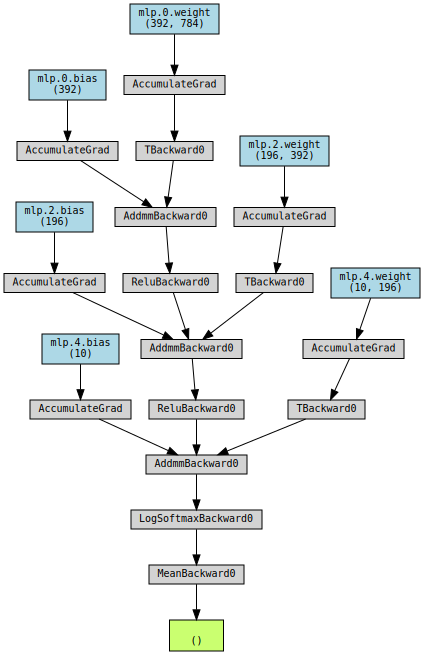

In [25]:
full_model.draw_network()

In [42]:
full_model.to(full_model.get_device())
fit_kwargs = dict(n_epochs=100, verbose_step=10, track_loss=True)


In [43]:
full_model = get_fit_model(
    full_model, "full_model", training_data, fit_kwargs=fit_kwargs, force_train=False
)


No model found at trained_models\full_model.pt. Fitting...
Loss: 1.646301 [    1/  100]
Loss: 0.219671 [   10/  100]
Loss: 0.129729 [   20/  100]
Loss: 0.086360 [   30/  100]
Loss: 0.060977 [   40/  100]
Loss: 0.044628 [   50/  100]
Loss: 0.033082 [   60/  100]
Loss: 0.024938 [   70/  100]
Loss: 0.019121 [   80/  100]
Loss: 0.014773 [   90/  100]
Loss: 0.011538 [  100/  100]
Model fit, saving weights to trained_models\full_model.pt.


Text(0.5, 1.0, 'Baseline mdoel - No regularization')

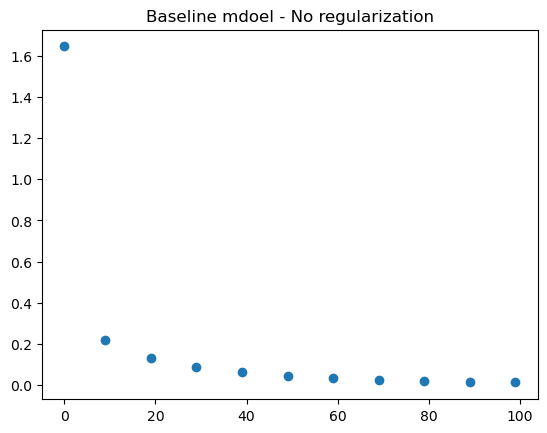

In [44]:
plt.scatter(full_model.epochs_, full_model.mean_loss_)
plt.title("Baseline mdoel - No regularization")


In [45]:
full_model_train_results = evaluate_model(full_model, training_data, "train")

Mean train MCC 1.00, Mean loss: 0.0108298


In [46]:
full_model_test_results = evaluate_model(full_model, test_data, "test")

Mean test MCC 0.98, Mean loss: 0.0650404


## Early Stopping: Full Model

In [47]:
full_model_es = MnistMLP(rate=0.01, h1_size=392, h2_size=196)
print(full_model_es)


MnistMLP(
  (mlp): Sequential(
    (0): Linear(in_features=784, out_features=392, bias=True)
    (1): ReLU()
    (2): Linear(in_features=392, out_features=196, bias=True)
    (3): ReLU()
    (4): Linear(in_features=196, out_features=10, bias=True)
    (5): LogSoftmax(dim=1)
  )
  (loss): NLLLoss()
)


In [48]:
early_stop_fit_kwargs = dict(
    n_epochs=100,
    verbose=True,
    verbose_step=10,
    track_loss=True,
    early_stopping=True,
    test_loader=test_data,
    early_step_size=1,
)
full_model_es = get_fit_model(
    full_model_es,
    "full_model_es",
    training_data,
    fit_kwargs=early_stop_fit_kwargs,
    force_train=False,
)


No model found at trained_models\full_model_es.pt. Fitting...
Loss: 1.609998 [    1/  100]
Loss: 0.216002 [   10/  100]
Loss: 0.128135 [   20/  100]
Loss: 0.083812 [   30/  100]
Loss: 0.058837 [   40/  100]
Loss: 0.042894 [   50/  100]
Loss: 0.032052 [   60/  100]
Loss: 0.024130 [   70/  100]
Loss: 0.018426 [   80/  100]
Loss: 0.014308 [   90/  100]
Loss: 0.011206 [  100/  100]
Model fit, saving weights to trained_models\full_model_es.pt.


Mean train MCC 1.00, Mean loss: 0.0108272


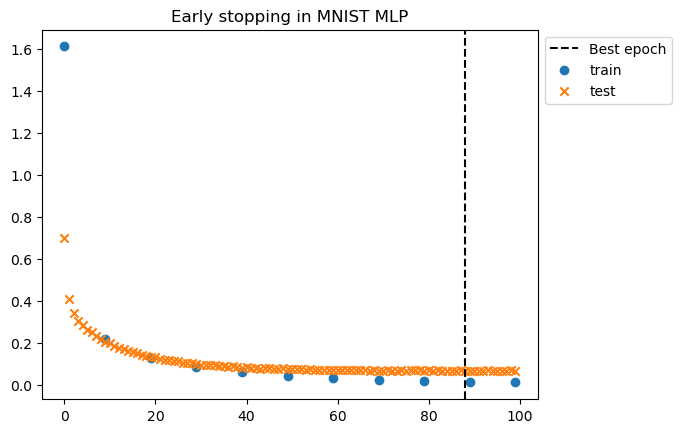

In [51]:
plot_early_stop(full_model_es, "Early stopping in MNIST MLP")
full_model_es_train_results = evaluate_model(full_model_es, training_data, "train")


In [52]:
full_model_es_test_results = evaluate_model(full_model_es, test_data, "test")

Mean test MCC 0.98, Mean loss: 0.0676947


## Adversarial Training

In [53]:
adv_model = AdversarialMLP(
    rate=0.01, h1_size=392, h2_size=196, epsilon=0.005, alpha=0.5
)
print(adv_model)


AdversarialMLP(
  (mlp): Sequential(
    (0): Linear(in_features=784, out_features=392, bias=True)
    (1): ReLU()
    (2): Linear(in_features=392, out_features=196, bias=True)
    (3): ReLU()
    (4): Linear(in_features=196, out_features=10, bias=True)
    (5): LogSoftmax(dim=1)
  )
  (loss): NLLLoss()
  (normalize_image_): Normalize(mean=0, std=1)
)


In [54]:
adv_model = get_fit_model(
    adv_model, "adv_model", training_data, fit_kwargs=fit_kwargs, force_train=False
)


No model found at trained_models\adv_model.pt. Fitting...
Loss: 1.726916 [    1/  100]
Loss: 0.219388 [   10/  100]
Loss: 0.131414 [   20/  100]
Loss: 0.087388 [   30/  100]
Loss: 0.061526 [   40/  100]
Loss: 0.045073 [   50/  100]
Loss: 0.033786 [   60/  100]
Loss: 0.025591 [   70/  100]
Loss: 0.019373 [   80/  100]
Loss: 0.014973 [   90/  100]
Loss: 0.011700 [  100/  100]
Model fit, saving weights to trained_models\adv_model.pt.


Text(0.5, 1.0, 'Full model with adversarial training')

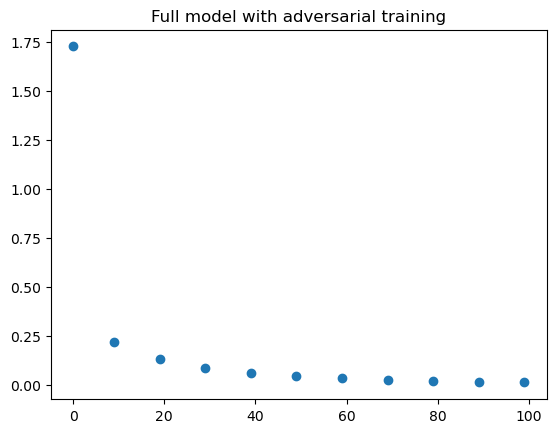

In [55]:
plt.scatter(adv_model.epochs_, adv_model.mean_loss_)
plt.title("Full model with adversarial training")


In [57]:
full_model_adv_train_results = evaluate_model(adv_model, training_data, "train")

Mean train MCC 1.00, Mean loss: 0.0110296


In [59]:
full_model_adv_test_results = evaluate_model(adv_model, test_data, "test")

Mean test MCC 0.98, Mean loss: 0.0627081


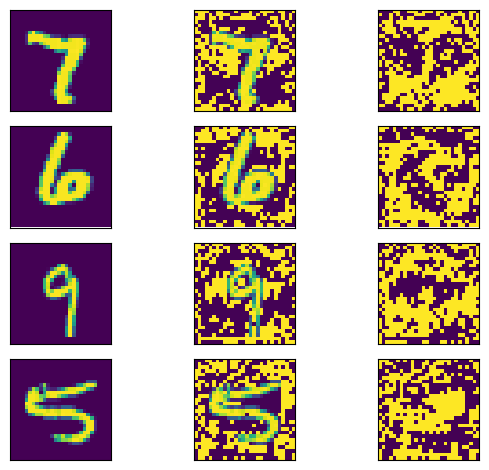

In [60]:
X, y = next(iter(test_data))
show_adversarial(X, y, adv_model, n_images=4)


## Adversarial with Early Stopping

In [61]:
adv_model_es = AdversarialMLP(
    rate=0.01, h1_size=392, h2_size=196, epsilon=0.005, alpha=0.5
)
print(adv_model_es)


AdversarialMLP(
  (mlp): Sequential(
    (0): Linear(in_features=784, out_features=392, bias=True)
    (1): ReLU()
    (2): Linear(in_features=392, out_features=196, bias=True)
    (3): ReLU()
    (4): Linear(in_features=196, out_features=10, bias=True)
    (5): LogSoftmax(dim=1)
  )
  (loss): NLLLoss()
  (normalize_image_): Normalize(mean=0, std=1)
)


In [62]:
adv_model_es = get_fit_model(
    adv_model_es,
    "adv_model_es",
    training_data,
    fit_kwargs=early_stop_fit_kwargs,
    force_train=False,
)


No model found at trained_models\adv_model_es.pt. Fitting...
Loss: 1.625637 [    1/  100]
Loss: 0.217491 [   10/  100]
Loss: 0.129339 [   20/  100]
Loss: 0.086466 [   30/  100]
Loss: 0.061291 [   40/  100]
Loss: 0.044706 [   50/  100]
Loss: 0.033051 [   60/  100]
Loss: 0.024860 [   70/  100]
Loss: 0.018898 [   80/  100]
Loss: 0.014583 [   90/  100]
Loss: 0.011425 [  100/  100]
Model fit, saving weights to trained_models\adv_model_es.pt.


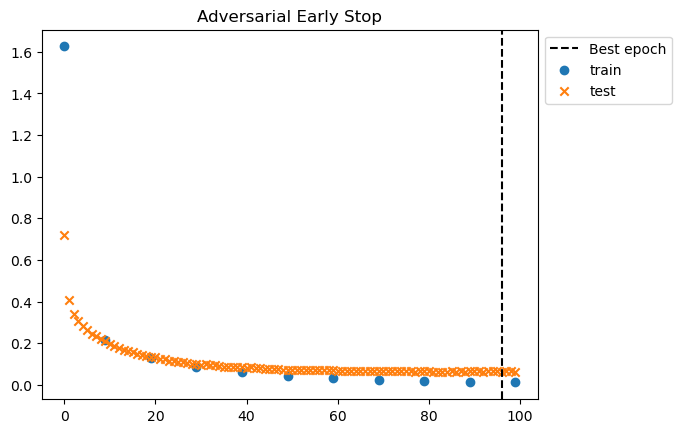

In [63]:
plot_early_stop(adv_model_es, "Adversarial Early Stop")

In [64]:
adv_model_es_train_results = evaluate_model(adv_model_es, training_data, "train")
adv_model_es_test_results = evaluate_model(adv_model_es, test_data, "test")


Mean train MCC 1.00, Mean loss: 0.0105833
Mean test MCC 0.98, Mean loss: 0.0640558


## Regularization via Dropout

In [65]:
dropout = DropOutMLP(
    rate=0.01, h1_size=392, h2_size=392 // 2, p_dropout_in=0.5, p_dropout_h=0.8
)
print(dropout)


DropOutMLP(
  (mlp): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=784, out_features=392, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.8, inplace=False)
    (4): Linear(in_features=392, out_features=196, bias=True)
    (5): Dropout(p=0.8, inplace=False)
    (6): ReLU()
    (7): Dropout(p=0.8, inplace=False)
    (8): Linear(in_features=196, out_features=10, bias=True)
    (9): LogSoftmax(dim=1)
  )
  (loss): NLLLoss()
)


In [66]:
dropout = get_fit_model(
    dropout,
    "dropout",
    training_data,
    fit_kwargs=early_stop_fit_kwargs,
    force_train=False,
)


No model found at trained_models\dropout.pt. Fitting...
Loss: 2.422000 [    1/  100]
Loss: 2.301828 [   10/  100]
Loss: 2.301831 [   20/  100]
Loss: 2.301827 [   30/  100]
Loss: 2.301836 [   40/  100]
Loss: 2.301830 [   50/  100]
Loss: 2.301825 [   60/  100]
Loss: 2.301826 [   70/  100]
Loss: 2.301836 [   80/  100]
Loss: 2.301836 [   90/  100]
Loss: 2.301834 [  100/  100]
Model fit, saving weights to trained_models\dropout.pt.


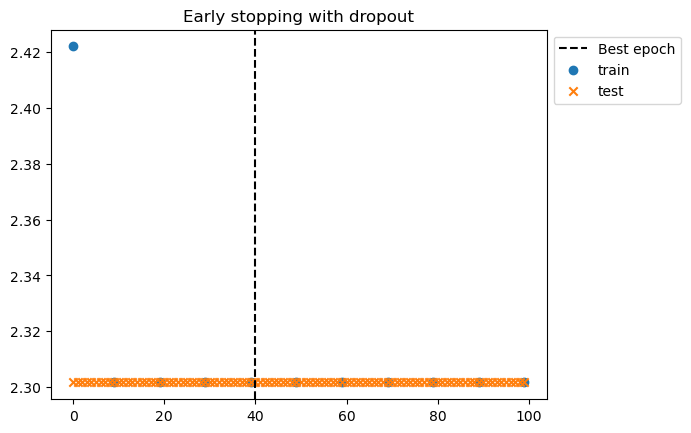

In [67]:
plot_early_stop(dropout, "Early stopping with dropout")

In [68]:
dropout_train_results = evaluate_model(dropout, training_data, "train")
dropout_test_results = evaluate_model(dropout, test_data, "test")


Mean train MCC 0.00, Mean loss: 2.3018298
Mean test MCC 0.00, Mean loss: 2.3018444


In [69]:
adv_dropout = AdversarialDropOut(
    rate=0.01,
    h1_size=392,
    h2_size=392 // 2,
    p_dropout_in=0.5,
    p_dropout_h=0.8,
    epsilon=0.004,
    alpha=0.5,
)
print(adv_dropout)


AdversarialDropOut(
  (mlp): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=784, out_features=392, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.8, inplace=False)
    (4): Linear(in_features=392, out_features=196, bias=True)
    (5): Dropout(p=0.8, inplace=False)
    (6): ReLU()
    (7): Dropout(p=0.8, inplace=False)
    (8): Linear(in_features=196, out_features=10, bias=True)
    (9): LogSoftmax(dim=1)
  )
  (loss): NLLLoss()
)


In [71]:
adv_dropout = get_fit_model(
    adv_dropout,
    "adv_dropout",
    training_data,
    fit_kwargs=early_stop_fit_kwargs,
    force_train=False,
)


Previously trained model discovered, loading model.


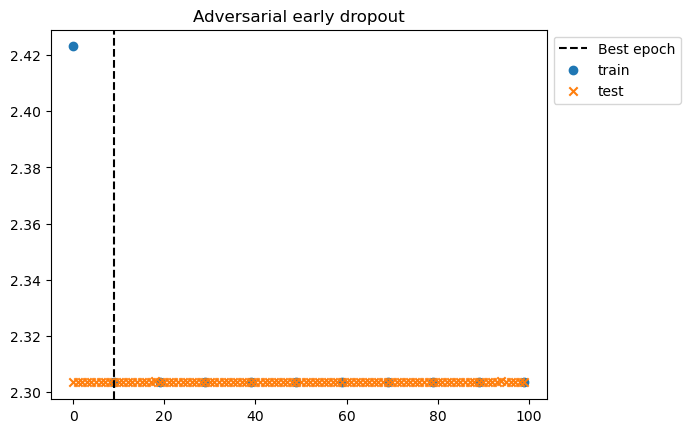

In [72]:
plot_early_stop(adv_dropout, "Adversarial early dropout")

## Results

We see from the printed results, that the full model along with the L1 + L2 **weight** regularized models achieve similar test results, with L2 performing the best with MCC=0.99. Likewise, we see L2 weight decay set via `SGD` results in an underfit model -- possibly due to regularization of biases. These results are explored graphically below. 

In [24]:
import pandas as pd
import seaborn as sns

dfs = []
for model, name in zip(
    [full_model, weight_decay_model, l2_model, l1_model],
    ["full", "weight decay", "L2", "L1"],
):
    dfs.append(
        pd.DataFrame(
            {
                "mean_loss": model.mean_loss_,
                "loss_std": model.std_loss_,
                "epoch": model.epochs_,
                "model": name,
            }
        )
    )

In [25]:
training_df = pd.concat(dfs)
training_df.head()

,mean_loss,loss_std,epoch,model
0,1.501318,0.596629,0,full
1,0.208726,0.084429,9,full
2,0.121589,0.062131,19,full
3,0.079487,0.049735,29,full
4,0.054551,0.038203,39,full


Text(0.0, 1.0, 'Loss during training')

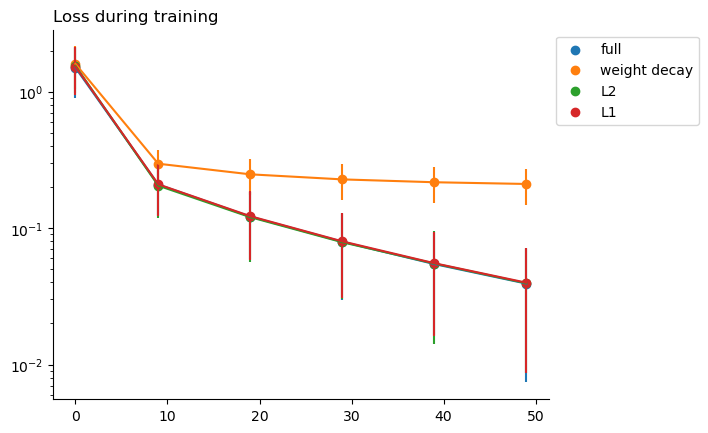

In [52]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots()
for each in training_df.model.unique():
    subset = training_df.query("model == @each")
    ax.scatter(subset.epoch, subset.mean_loss, label=each)
    ax.errorbar(subset.epoch, subset.mean_loss, yerr=subset.loss_std)
ax.set_yscale("log")
ax.spines[["top", "right"]].set_visible(False)
ax.legend(loc="upper left", bbox_to_anchor=(1, 1))
ax.set_title("Loss during training", loc="left")

In [82]:
dfs = []
results = {
    "train": {
        "full": full_model_train_results,
        "decay": weight_decay_model_train_results,
        "L2": l2_model_train_results,
        "L1": l1_model_train_results,
    },
    "test": {
        "full": full_model_test_results,
        "decay": weight_decay_model_test_results,
        "L2": l2_model_test_results,
        "L1": l1_model_test_results,
    },
}
for split, data in results.items():
    for key, res in data.items():
        dfs.append(
            pd.DataFrame({"MCC": res[0], "Loss": res[1], "Model": key, "Split": split})
        )

In [83]:
results_df = pd.concat(dfs).melt(id_vars=["Model", "Split"])
results_df.head()

,Model,Split,variable,value
0,full,train,MCC,0.964807
1,full,train,MCC,1.000000
2,full,train,MCC,0.982659
3,full,train,MCC,1.000000
4,full,train,MCC,0.982774


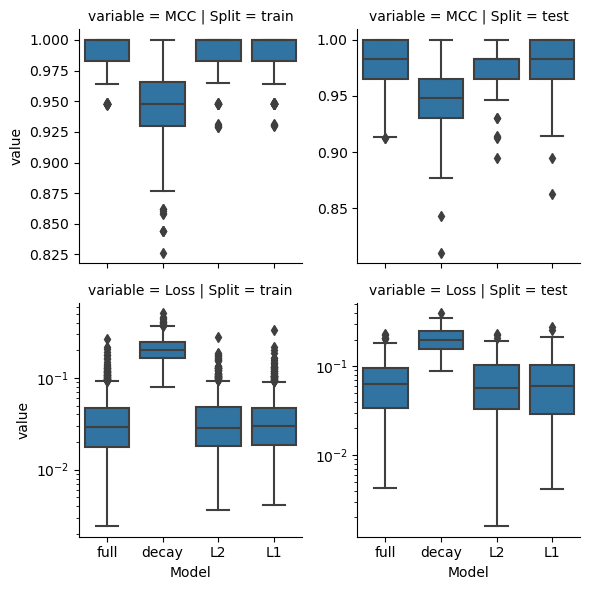

In [84]:
g = sns.FacetGrid(results_df, row="variable", col="Split", sharey=False)
g.map_dataframe(sns.boxplot, x="Model", y="value")
for ax in g.axes[1, :]:
    ax.set_yscale("log")